# NEWS_crawling

In [1]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [2]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [3]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [4]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

In [5]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

# 1년 간의 데이터를 수집

In [6]:
def make_1_year_data(page_num, code_list, date):
    df = None
    
    for i in range(0,12):
        df_temp = make_total_data(page_num, code_list, date+i*101)
            
            
        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
            
    return df

# 데이터 프레임 생성 및 저장

In [7]:
#df = make_1_year_data(5, code_list, 20190104)

In [8]:
#type(df)

In [9]:
#import os
#csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data2.csv"
#df.to_csv(csv_path, index=False)

#if os.path.exists(csv_path):
  #print('{} File Saved!'.format(csv_path))

In [10]:
import pandas as pd
import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data2.csv"
df = pd.read_table(csv_path, sep=',')

In [11]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3600


In [12]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       오늘일 오후 시 분쯤 경북 군위군 산성면 백학리에서 산불이 발생했습니다산림청과 소방...
1       아시아경제 호남취재본부 김춘수 기자 광주 서부경찰서는 편의점에 흉기를 꺼내 들고 들...
2       사진한국천문연구원 제공일 밤 시 분부터 많은 사람들이 별똥별을 볼 생각에 목이 빠져...
3       안양시의회 적십자 특별회비 전달 사진제공안양시의회안양강근주 기자 안양시의회는 일 안...
4       일 서울 서대문구 신촌동 연세대학교 학생회관 로비에 총여학생회 폐지에 반대하는 내용...
                              ...                        
3595    하현회 유플러스 부회장 하현회 유플러스 부회장  전자신문  전자신문인터넷 무단전재 ...
3596    과학기술정보통신부가 유플러스의 헬로 인수에 대한 심사결과 조건부 인가를 승인했다 일...
3597      전자신문  전자신문인터넷 무단전재 및 재배포 금지유플러스의 헬로 인수는 일 만에...
3598    기사 섹션 분류 안내기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다 언론사...
3599    월 일 오후 시 분에 서해 덕적도 인근 경기만 해역에서 규모 의 지진이 발생했습니다...
Name: news, Length: 3600, dtype: object

# NULL값 확인 및 중복된 샘플 제거

In [13]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [14]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3189


In [15]:
# 중복 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3189


<AxesSubplot:>

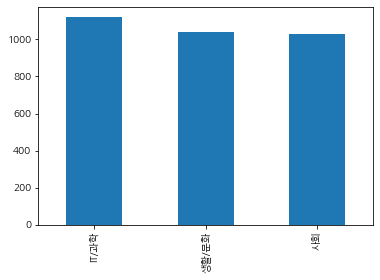

In [16]:
import matplotlib as mpl
import matplotlib.pylab as plt

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'


df['code'].value_counts().plot(kind = 'bar')

In [17]:
from konlpy.tag import Mecab
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Okt
tokenizer = Mecab()

# 불용어 처리

In [18]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스','까지', '고', '지','렸', '되','현지', '재배포','일보','혔','를','함께', '된', '졌','송고','연합뉴스','었','였','저작권자','겟']

In [19]:
len(stopwords)

50

In [20]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [21]:
text_data = preprocessing(df['news'])

# 데이터 분리 및 테스트 결과 확인

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [23]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'],test_size=0.3,random_state = 0)

In [24]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2232
테스트용 뉴스 기사의 개수 :  957
훈련용 레이블의 개수 :  2232
테스트용 레이블의 개수 :  957


In [25]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [26]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [27]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.79      0.96      0.87       351
          사회       0.85      0.82      0.83       294
       생활/문화       0.84      0.68      0.75       312

    accuracy                           0.82       957
   macro avg       0.83      0.82      0.82       957
weighted avg       0.83      0.82      0.82       957



# 결과 분석 및 과정

# step1: 형태소 분석기 변경해보기
    
Mecab을 사용했을때의 가장 큰 장점은 학습시간이 매우 빠르다는 것이었다. 정확도도 비교적 높은 값을보였다. 불용어 추가, 다른 날짜 데이터 추가등 여러가지 방법으로 학습데이터를 변경하기 위하여 Mecab을 사용하였다.

# step2: 불용어 추가해 보기
    
기사에서 자주사용되는 의미없는 말들을 하나 둘씩 분석하고, 리스트에 추가시켰더니 정확도가 향상되는 것을 알 수 있었다.

# step3: 다른 날짜 데이터 추가해보기

시간, 계절등에 데이터분석에 영향을 받지 않기 위해 1월~12월의 데이터를 골고루 수집하여 학습을 시켰다. 생각외로 상당히 효과적인 방법이었다.